# TensorFlow Tutorials
# Loading and Preprocessing Data 04: Images

Using `tf.data.Dataset` to read in image data. Data in this example is distributed in directories, where each directory represents one class.

## Workspace Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# After much experimentation, I found that using TF 2 avoids most errors
try:
  !pip install tf-nightly
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.1.0-dev20191003'

In [0]:
# Allow tensorflow to automatically select number of elements for prefetching 
# Has to do with tensor pipeline efficiency: how quickly is data available for training
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
# Helper libraries
import IPython.display as display    # displaying images in the IPython console (console output)
from PIL import Image                # PIL = Python Image Library - Image is an obj for representing pictures
import numpy as np
import matplotlib.pyplot as plt 

In [5]:
# This shoud be 2.0. Why is it 1.14?
tf.__version__

'2.1.0-dev20191003'

## Retreiving Images

In [0]:
import pathlib

In [0]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)

In [0]:
# Remember the path to this directory
data_dir = pathlib.Path(data_dir)

In [9]:
# How many images do we have?
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [10]:
# Names of classes in the dataset - all items in the folder except for the LICENSE.txt 
# are subdirectories whose names represent the classes of flowers
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['daisy', 'roses', 'sunflowers', 'tulips', 'dandelion'],
      dtype='<U10')

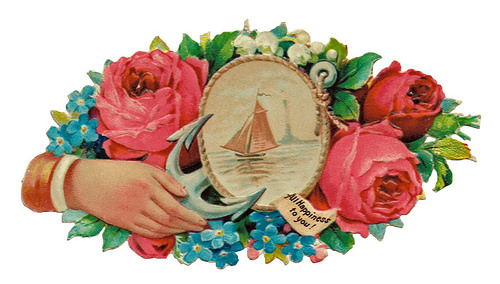

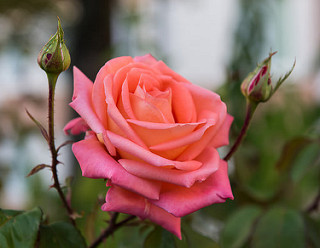

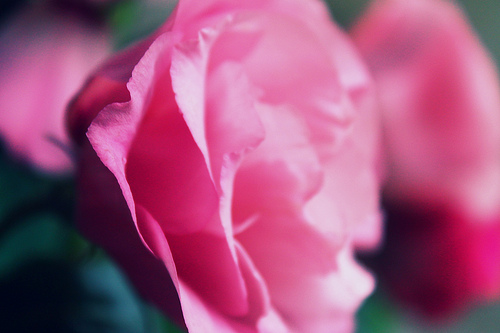

In [11]:
# Each directory contains images of that flower type
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

## Load Using `keras.preprocessing`

In [0]:
# Simplest way to load images - 1/255 converts px values from int to float in range [0, 1]
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
# Define some parameters for the ImageDataGenerator and loader
BATCH_SIZE=  32              # Number of images per batch output by the generator
IMG_HEIGHT = 224             # defining width and height of the image
IMG_WIDTH = 224

# For each epoch, the ImageDataGenerator should draw just enough batches to fully
# parse the entire dataset - hence the use of np.ceil
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [14]:
# Read in data from the directories using a data generator
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), 
                                                     batch_size=BATCH_SIZE, 
                                                     shuffle=True, 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [0]:
# Inspect a batch of images
def show_batch(image_batch, label_batch):
  # Create a figure of 10inches by 10 inches (standard dpi)
  plt.figure(figsize=(10, 10))

  # For the first 25 images
  for n in range(25):
    # Find the right axis using the subplot command (5, 5, n + 1) means
    # This will be plotted in the (n + 1)th axis in a subplot of 5 rows and 5 cols
    ax = plt.subplot(5, 5, n + 1)

    # Show the nth image
    plt.imshow(image_batch[n])

    # Annotate based on directory name
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())

    # Don't want to display axes with pixel qtys
    plt.axis('off')


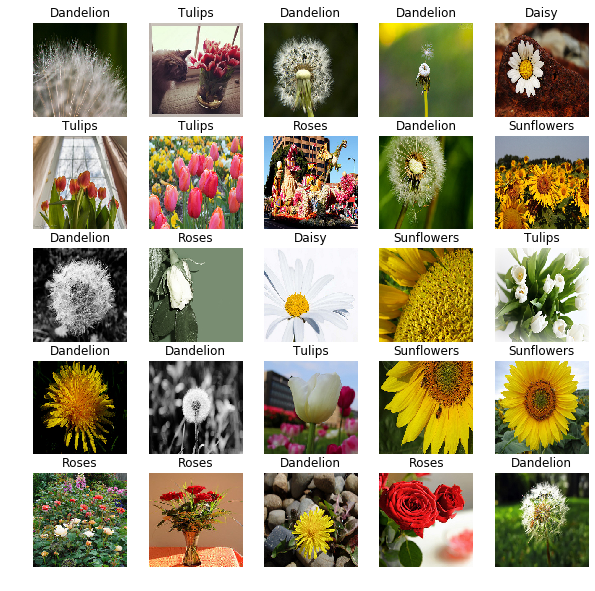

In [16]:
# Now extract a batch of labels and images from the datagen
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Loading Using `tf.data.Dataset`
The `keras.preprocessing` approach to loading images with data generators is convenient, but it does have its drawbacks. Specifically,
- it is slow
- it lacks fine-grained control
- it is not well-integrated with the rest of tensorflow

The `tf.data.Dataset` structure fixes all these problems.

In [21]:
# List of filepaths for all files in the dataset that conform to the data_dir/subdir/filename regex
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Examining the first 5 filepaths
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/16152175716_55d6968e08_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/9460336948_6ae968be93.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13513644515_a51470b899.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/21657726011_2c94e341bc_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/1426682852_e62169221f_m.jpg'


In [0]:
# A function that gets the label for an image using its filepath
def get_label(file_path):
  # Convert the filepath to a list of path components separated by /
  parts = tf.strings.split(file_path, '/')

  # The second to last is the class directory i.e. the label
  # The comparison returns a vector of booleans which is true when the name of the
  # directory matches the element of the class_names list
  return parts[-2] == CLASS_NAMES

In [0]:
# A function that transforms an image into a 3D tensor
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Use the `convert_image_dtype` function to cast unit8 to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)

  # Resize the image
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [0]:
# Return a tuple consisting of label and tensor representing each image
def process_path(file_path):
  label = get_label(file_path)

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Going to use `tf.data.Dataset.map` to create a dataset of `(image, label)` pairs. 

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/preprocessed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
# Use the first element to check that the data has been transformed properly
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False  True]


## Basic Methods of Training
Before training the model, the `tf.data.Dataset` objs containing the training samples and labels must be
- shuffled
- batched
- made available as soon as possible
All three of these objectives can be met with the `tf.data` API.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  """This is a small dataset. Only load it once and keep it in memory.
  Use .cache(filename) to cache preprocessing work for datasets that don't fit in memory"""
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # Shuffle
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  # Batch
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while model trains
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  
  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

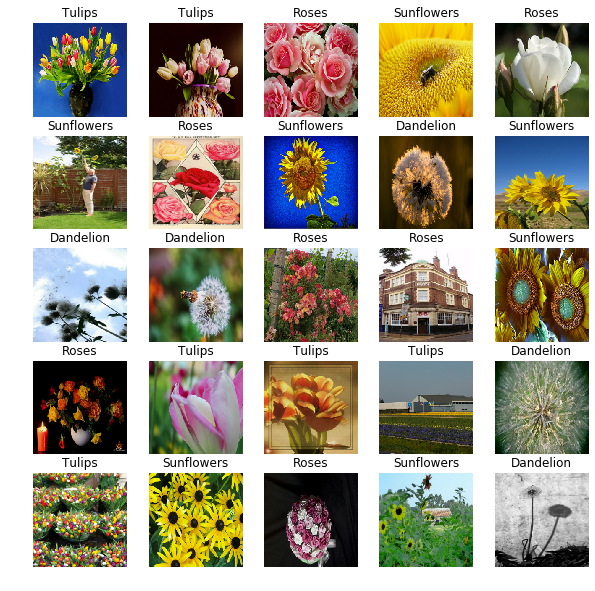

In [29]:
# We made this functon in the keras section
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

In [0]:
# Checking dataset/pipeline performance
import time

# default number of iterations/steps to run for timing purposes
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()                 # Record the time at at the beginning of the call
  it = iter(ds)                       # Iterator?
  for i in range(steps):              # For 1000 iterations
    batch = next(it)                  # Draw batches
    if i % 10 == 0:                   # Print a dot for every 10 batches drawn
      print('.', end="")
  print()                             # Print a newline after all batches drawn
  end = time.time()                   # Record time at the end of the call

  # Total duration of batches drawn by the pipeline
  duration = end - start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [32]:
# Keras preprocessing - tutorials time is ~83s, ~385 images per second
timeit(train_data_gen)

....................................................................................................
1000 batches: 104.23720669746399 s
306.99211 Images/s


In [33]:
# tf.data - tutorials time is ~9.4 seconds, 3417 images per second
timeit(train_ds)

....................................................................................................
1000 batches: 15.987850189208984 s
2001.51988 Images/s


In [34]:
# A large part of the performance gain coms from the use of .cache
# Considerably slower - tutorial time is 25.558s 1252 images/s
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 77.75757050514221 s
411.53549 Images/s


In [35]:
# If the dataset doesn't fit into memory, use a cache file to maintain some advantages
filecache_ds = prepare_for_training(labeled_ds, cache='./flowers.tfcache')
timeit(filecache_ds)

....................................................................................................
1000 batches: 54.30195903778076 s
589.29734 Images/s
